
---

## **The Story Setup — The Curious Analyst and the Leaky Wallet**

Imagine a data analyst named **Alex** at a top retail company.
He’s been given access to a **Snowflake Virtual Warehouse** (let’s call it `ANALYTICS_WH`) to run his queries and generate reports.

Here’s Alex’s work style:

* He runs a few queries in the morning.
* Then he spends a big chunk of time **thinking**, **brainstorming**, and **writing presentations** based on those results.
* Meanwhile, his warehouse is **just sitting there running**… quietly burning company money like an idle car with the engine on.

Snowflake **does not** care whether the warehouse is running queries or just twiddling its thumbs — if it’s **open**, it’s **billing**.

Our job? **Detect how much of that warehouse time was truly "active" vs "idle"** and **optimize it** to save costs.

---

## **Why Idle Time vs Active Time Matters**

Think of Snowflake’s VWH as a **hotel room**:

* **Active time** = You’re using the room (sleeping, working, living).
* **Idle time** = You’re still paying for it, but you’re outside sightseeing.

Too much idle time = money drain.
Too little warehouse sizing for your work = slow performance.

**Goal:**

* Avoid **over-utilization** → performance suffers.
* Avoid **under-utilization** → waste money.
* **Balance the two** by knowing exactly when your warehouse works and when it slacks off.

---

## **Step 1 — Understanding the Metadata Views**

Snowflake gives us **three superhero metadata views** (plus a powerful role) to crack the idle time mystery.

---

### **1. `WAREHOUSE_METERING_HISTORY` — The Billing Stopwatch**

Think of this as your **cost meter**.

**Purpose:** Shows warehouse usage and credits billed over time.

**Important columns:**

| Column                        | Purpose                                                       |
| ----------------------------- | ------------------------------------------------------------- |
| `START_TIME`                  | When this billing interval started                            |
| `END_TIME`                    | When it ended                                                 |
| `CREDITS_USED`                | How many credits were consumed in this interval               |
| `CREDITS_USED_COMPUTE`        | Compute credits (actual processing)                           |
| `CREDITS_USED_CLOUD_SERVICES` | Credits used for cloud services layer                         |
| `WAREHOUSE_NAME`              | Which warehouse we’re talking about                           |
| `AVG_RUNNING`                 | Average number of clusters running                            |
| `AVG_QUEUE_LOAD`              | Shows if queries were queuing (maybe warehouse was too small) |
| `AVG_EXECUTION_TIME`          | Average execution time in that billing period                 |

**Why important here?**
This is our **total "engine on" time** and **cost baseline**.

---

### **2. `QUERY_HISTORY` — The Activity Tracker**

This is **what Alex actually did** during the warehouse runtime.

**Important columns:**

| Column               | Purpose                            |
| -------------------- | ---------------------------------- |
| `QUERY_ID`           | Unique query identifier            |
| `WAREHOUSE_NAME`     | Which warehouse executed the query |
| `START_TIME`         | When query started                 |
| `END_TIME`           | When query finished                |
| `TOTAL_ELAPSED_TIME` | Time taken by query                |
| `BYTES_SCANNED`      | Amount of data processed           |
| `ROWS_PRODUCED`      | Output rows                        |
| `EXECUTION_STATUS`   | SUCCESS / FAILED / CANCELED        |
| `USER_NAME`          | Who ran the query                  |

**Why important here?**
It tells us **exactly when queries were executed** and **how long they ran** — our **active periods**.

---

### **3. `WAREHOUSE_EVENT_HISTORY` — The Gatekeeper Log**

This one records **state changes** for warehouses.

**Important columns:**

| Column            | Purpose                                                          |
| ----------------- | ---------------------------------------------------------------- |
| `EVENT_TIMESTAMP` | When the event happened                                          |
| `WAREHOUSE_NAME`  | Which warehouse                                                  |
| `EVENT_TYPE`      | START / STOP / RESUME / SUSPEND                                  |
| `USER_NAME`       | Who triggered the event                                          |
| `CLUSTER_NUMBER`  | Cluster involved                                                 |
| `REASON`          | Why it was started/stopped (manual, auto-suspend, scaling, etc.) |

**Why important here?**
It shows **when the warehouse was turned on or off** — the key to detecting idle gaps.

---

### **The Role Needed — `ACCOUNTADMIN`**

You need **`ACCOUNTADMIN`** or a role with access to the `SNOWFLAKE.ACCOUNT_USAGE` schema to query these views, because they’re **account-level metadata**.

---

## **Step 2 — Combining the Views to Detect Idle Time**

Now let’s merge the pieces:

1. **Find Warehouse Runtime:**

   * Use `WAREHOUSE_EVENT_HISTORY` to see **start** and **stop** times for each warehouse session.

2. **Find Queries Executed in That Window:**

   * Use `QUERY_HISTORY` filtered by `WAREHOUSE_NAME` and matching `START_TIME`–`END_TIME` windows.

3. **Match Against Billing Info:**

   * From `WAREHOUSE_METERING_HISTORY`, pull the credits used for that period.

4. **Calculate Idle Time:**

   * Idle time = `Warehouse open time` − `Sum of query execution times`
   * Idle cost = `(Idle time / Total open time) * Total credits used`

---

### **Real Case Scenario**

Let’s replay Alex’s day:

* **8:00 AM:** Alex resumes `ANALYTICS_WH` (manual start).
* **8:05 – 8:20 AM:** Runs a 15-minute query.
* **8:20 – 9:30 AM:** Thinks, writes notes, no queries. Warehouse still running.
* **9:30 – 9:35 AM:** Runs another short query.
* **9:35 – 10:00 AM:** More thinking time.
* **10:00 AM:** Auto-suspend finally kicks in.

**From logs:**

* `WAREHOUSE_EVENT_HISTORY` shows open time: 8:00 – 10:00 (2 hours).
* `QUERY_HISTORY` shows only **20 minutes total query time**.
* `WAREHOUSE_METERING_HISTORY` shows **1 credit consumed/hour** × 2 hours = **2 credits** billed.

**Idle Cost:**

* Active usage = 20 minutes (33%).
* Idle usage = 1 hour 20 minutes (67%).
* Cost wasted on idle = \~1.34 credits.

---

## **Step 3 — How to Optimize**

1. **Enable Auto-Suspend**

   * Set it low (e.g., **5 minutes**) so the warehouse stops when not in use.

2. **Educate Users**

   * Teach Alex and others to **resume on demand**.

3. **Use Smaller Warehouses for Interactive Analysis**

   * If queries are light, use `X-SMALL` or `SMALL` instead of `LARGE`.

4. **Leverage Multi-Cluster for Peak Only**

   * Avoid always-on large clusters.

5. **Build a Dashboard**

   * Combine these views in a BI tool (e.g., Tableau, Power BI, Looker) to:

     * Show **% active vs idle time**
     * Show **idle cost in credits and dollars**
     * Identify **users with highest idle time**

---

## **Extra Nuggets People Often Miss**

* **Cloud Services Cost**: Even if compute is suspended, certain operations (like metadata queries) can still cost credits.
* **Queued Queries**: From `WAREHOUSE_METERING_HISTORY.AVG_QUEUE_LOAD` — may indicate need for scaling or better scheduling.
* **Concurrent Scaling**: More clusters can spin up if needed — but each costs money during runtime.

---

## **Key Questions You Should Be Able to Answer**

1. How does Snowflake bill warehouses — is it per query or per running time?
2. Which metadata views would you use to calculate idle time, and what does each provide?
3. How would you calculate idle cost for a warehouse in a given week?
4. How does `AUTO_SUSPEND` impact idle time and cost?
5. How would you combine warehouse and query metadata to build a utilization dashboard?
6. What’s the difference between `CREDITS_USED_COMPUTE` and `CREDITS_USED_CLOUD_SERVICES`?
7. What situations could still incur costs when your warehouse is suspended?
8. How can you decide the right warehouse size for a team doing both heavy queries and light ad-hoc analysis?

---


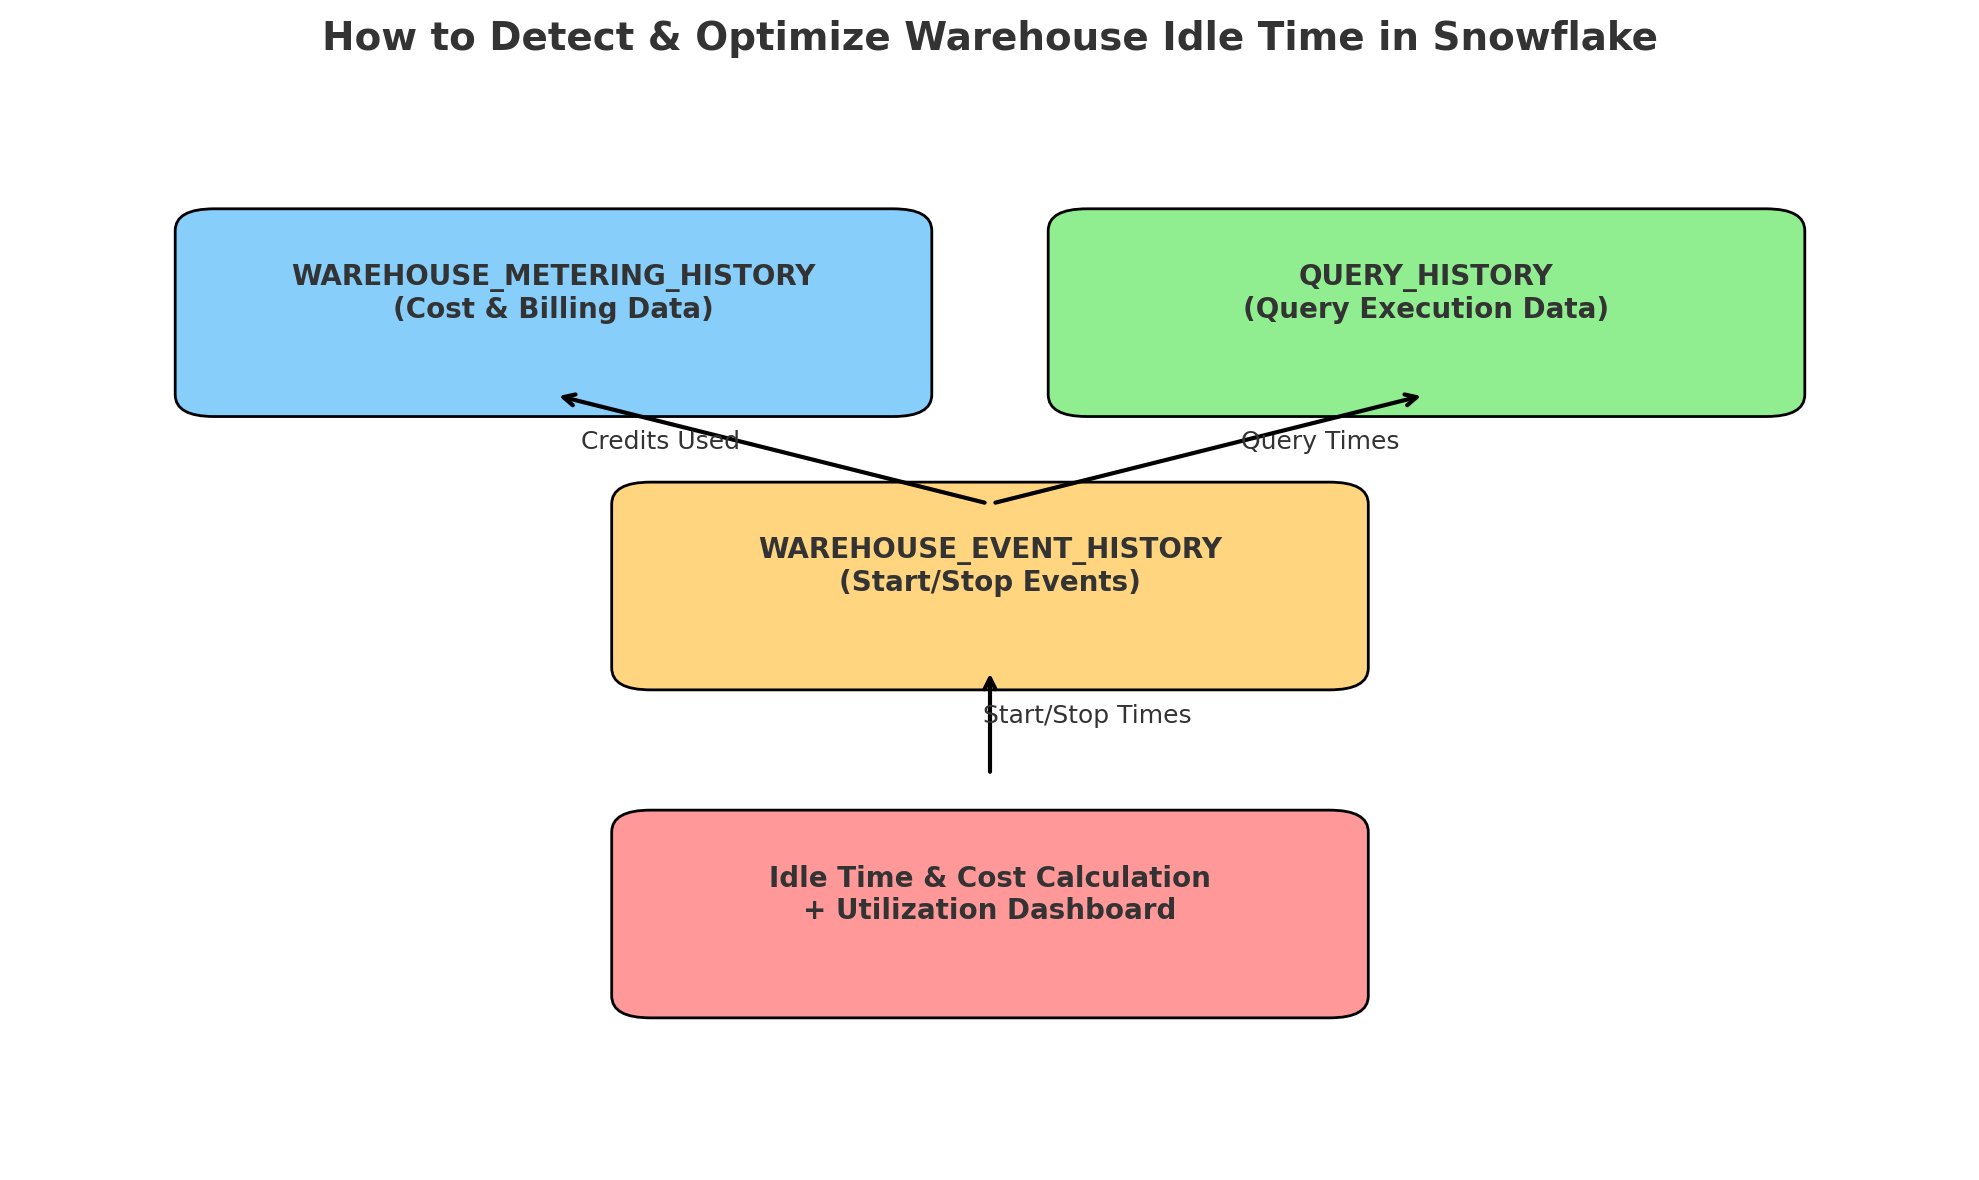


---

## **1. How does Snowflake bill warehouses — is it per query or per running time?**

**Answer:**
Snowflake bills **per-second** of warehouse runtime (with a 60-second minimum) based on the size of the warehouse, **not** per query.
If the warehouse is running, you’re paying — whether it’s executing queries or sitting idle.

**Example:**
If your `SMALL` warehouse runs for 15 minutes (including idle), you’ll pay for 900 seconds at the per-second rate.

---

## **2. Which metadata views would you use to calculate idle time, and what does each provide?**

**Answer:**

* **`WAREHOUSE_METERING_HISTORY`** → Cost and usage data (credits used, average clusters, queue load, etc.)
* **`QUERY_HISTORY`** → Exact query execution details (start/end time, elapsed time, user, warehouse, etc.)
* **`WAREHOUSE_EVENT_HISTORY`** → Start, stop, resume, and suspend events for warehouses.

These three combined give the **billing window**, **active query times**, and **warehouse state changes** to detect idle time.

---

## **3. How would you calculate idle cost for a warehouse in a given week?**

**Answer:**

1. Use `WAREHOUSE_EVENT_HISTORY` to find each start/stop session for the warehouse.
2. Use `QUERY_HISTORY` to sum the actual execution time during each session.
3. Get total credits used from `WAREHOUSE_METERING_HISTORY`.
4. Idle time = Warehouse open time − Sum of active query times.
5. Idle cost = `(Idle time / Total open time) × Total credits used`.

---

## **4. How does `AUTO_SUSPEND` impact idle time and cost?**

**Answer:**
`AUTO_SUSPEND` automatically shuts down the warehouse after a specified idle period (no running queries), reducing idle time cost.
The shorter the `AUTO_SUSPEND` setting (e.g., 5 minutes), the less you pay for idle runtime — but too short can cause frequent start delays for users.

---

## **5. How would you combine warehouse and query metadata to build a utilization dashboard?**

**Answer:**

1. Pull **warehouse runtime sessions** from `WAREHOUSE_EVENT_HISTORY`.
2. Pull **active queries** within those sessions from `QUERY_HISTORY`.
3. Pull **credit consumption** from `WAREHOUSE_METERING_HISTORY`.
4. Calculate:

   * % Active vs Idle time
   * Idle cost (credits & currency)
   * Query volume & performance metrics
   * User-level idle contribution
5. Visualize trends over time to find optimization opportunities.

---

## **6. What’s the difference between `CREDITS_USED_COMPUTE` and `CREDITS_USED_CLOUD_SERVICES`?**

**Answer:**

* **`CREDITS_USED_COMPUTE`** = Cost for actual warehouse compute power running queries.
* **`CREDITS_USED_CLOUD_SERVICES`** = Cost for cloud services layer (metadata operations, query parsing, optimization, result caching).
  Cloud services cost can appear **even when warehouse is suspended** if metadata queries are run.

---

## **7. What situations could still incur costs when your warehouse is suspended?**

**Answer:**

* Running queries that only use the cloud services layer (e.g., `SHOW`, `DESCRIBE`, `USE DATABASE`) — billed in `CREDITS_USED_CLOUD_SERVICES`.
* If other warehouses are running, their cloud services cost may be shared.
* If multi-cluster warehouses have residual active clusters before full suspension.

---

## **8. How can you decide the right warehouse size for a team doing both heavy queries and light ad-hoc analysis?**

**Answer:**

* Use a **smaller warehouse** (e.g., `X-SMALL` or `SMALL`) for light analysis to reduce idle cost.
* Scale up temporarily or use **multi-cluster mode** during peak demand.
* Monitor `AVG_QUEUE_LOAD` to know when queries are queuing (too small) or sitting idle (too big).

---
